*Before we get started, please note that I put in magic pip install lines to install everything this code needs to run locally, uncomment if you need to.*

In [83]:
# %pip install pandas
# %pip install matplotlib
# %pip install sklearn
# %pip install seaborn
# %pip install numpy
# %pip install shap

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.tree import plot_tree
from sklearn import metrics
import seaborn as sns
import numpy as np
from scipy import stats

import shap


*below is the line to let you can switch the dark mode plots off if you wish, just change I_like_dark_mode_plots = True to False and the colors will update*

In [85]:
I_like_dark_mode_plots = True

In [86]:
if I_like_dark_mode_plots:
    custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
    sns.set_style("darkgrid", rc=custom_style)
    plt.style.use("dark_background")

In [172]:
#setting custom colors for later
my_blue = '#2B59C3'
my_green = '#63C132'
my_red = '#DA2C38'

# Predicting Churn from Iranian Telecom Customer Data
*Data graciously hosted by UC Irvine at DOI:[10.24432/C5JW3Z](https://doi.org/10.24432/C5JW3Z)*

This project is all about constructing an effective binary classification model to predict customer churn from a variety of data randomly collected by an Iranian telecom company. By the end of this writeup we'll have a very effective model for predicting customer churn, explored the feature importance of that model, and proposed next steps. In the bonus section we'll also use probability tuning to turn our binary prediction into a probabilistic one without hurting the f1 score.

Table of contents
1. [Introduction to the dataset](#1)
2. [Exploratory data analysis](#2)
3. Naive model training for benchmarking
4. Hyperparameter searching
5. Choosing a model
6. Final model performance and feature importance
7. Conclusions, suggested next steps
8. BONUS: Turning our model output into a probability of churn

## Introduction to the dataset <a class="anchor" name="1"></a>
The dataset comes clean, with no missing values for 3150 customers. It has 9 months of data for the features. The label, churn, is evaluated at the 12 month mark. It has the following columns, sorted by type.

- Features
    - Binary
        - Complains (0: did not complain during the time period, 1: did complain during the time period)
        - Tariff Plan (1: Pay as you go, 2: Contractual)
        - Status (1: active, 2: non-active, what this means is not stated)
    - Ordinal
        - Charge Amount (0: lowest amount, 9: highest amount)
        - Age Group (1: youngest age group, 5: oldest age group)
    - Continuous
        - Call  Failure (int, number of call failures)
        - Seconds of Use (int, total seconds of calls)
        - Frequency of use (int, total number of calls)
        - Frequency of SMS (int, total number of text messages)
        - Distinct Called Numbers (int, total number of distinct phone calls)
        - Customer Value (float, the value of the customer, method and denomination not stated)
        - Age (int, seems to be the center of the age group bin the customer is in)
        - Subscription  Length (int, likely taken at the end of the 9 month period)
- Labels
    - Churn (binary, int, 0: did not churn between 9 and 12 months, 1: did churn between 9 and 12 months)

I will use all features except age and status. I neglect age because it is functionally a repetition of age group and neglet status because I'm not able to find out the meaning of it and want to avoid data leakage.

In [88]:
df = pd.read_csv("data/Customer Churn.csv", delimiter=",")
cont_keys = ['Call  Failure', 'Seconds of Use' , 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value', 'Subscription  Length']
ordinal_keys = ['Age Group', 'Charge  Amount']
binary_keys = ['Tariff Plan', 'Complains']

predictor_keys = [x for x in df.keys() if not (x  in ['Churn', 'Status', 'Age'])]
label_key = ['Churn']
df.head()
df = df[predictor_keys+label_key]

## Exploratory data analysis <a class="anchor" name="2"></a>

First let's check for any missing data

In [89]:
df.isnull().sum()

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Customer Value             0
Churn                      0
dtype: int64

No missing data we have to deal with. Let's look at our label distribution

In [90]:
df.Churn.value_counts(normalize = True)

Churn
0    0.842857
1    0.157143
Name: proportion, dtype: float64

Again, 1 is that the customer churned between 9 and 12 months and 0 is they did not. The majority of customers didn't churn which is great! The label classes are heavily imbalanced, [~84.3%,~15.7%]. Instead of resampling we'll keep it in mind and change the class weights down the line, I prefer this to resampling if it's available.

Let's take a look at the histograms of all our continuous variables

In [91]:
df[[x for x in df.keys() if x in cont_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()

Every continuous variable is non-normal here. Even subscription length, which is the closest to normal, has a giant left sided tail. I notice an interesting wavy pattern in frequency of use, frequency of sms, and customer value where there seems to be some kind of attenuating bouncing. Could be worth future investigation but shouldn't effect our prediction.

Let's see what the histograms for the ordinal and binary values look like

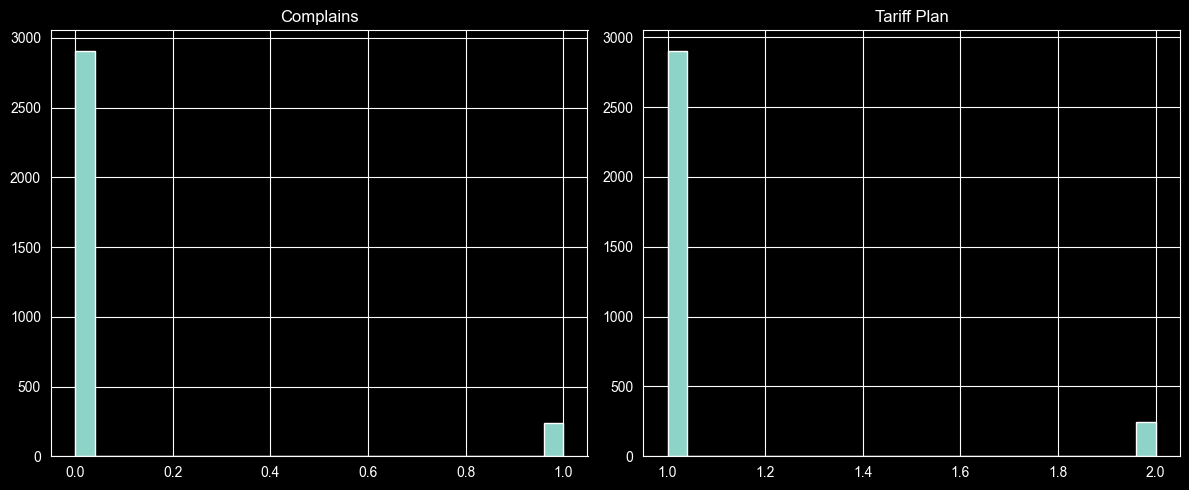

In [92]:
df[[x for x in df.keys() if x in ordinal_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()
df[[x for x in df.keys() if x in binary_keys]].hist(bins=25, figsize= (12,5))
plt.tight_layout()

Charge amount is going down exponentially, age group is about normal, and both complains and tariff plan are heavily biased towards a single class.

Later on we'll rescale everything to the [0,1] range using the pipeline objects in sklearn so the transformation is done inside the model.

Let's look at how the data relates to each other using a correlation matrix.

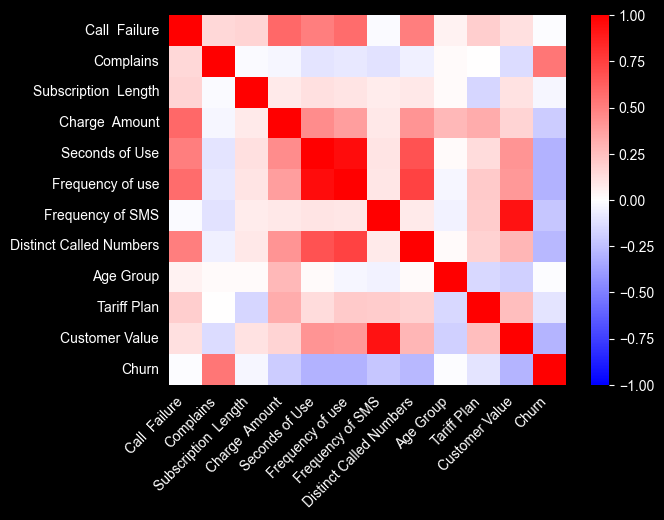

In [93]:
sns.heatmap(df.corr(), 
            xticklabels = df.columns.values, 
            yticklabels = df.columns.values, 
            cmap = 'bwr', vmin = -1, vmax = 1)
plt.xticks(rotation=45, ha='right');

So first, the non churn variables, here's what I'm seeing
- All the call usage variables are heavily correlated with each other, if this was going to be a causal model that'd be an issue and we'll have to keep it in mind for later when we do interpretability.
- Customer value heavily correlates with SMS which at first made me think we'd have to watch out for freq of SMS being heavily correlated with something else (like age group) such that customer value then could be mostly made up of that SMS correlated variable; however, SMS freq is only middling correlated with anything else so no worries.
- Looking now at churn only
    - For the continuous variables, in short it seems that the more someone uses the service, it's somewhat less likely they'll churn
    - For the ordinal variables, age doesn't seem to affect churn and charge amount has a suprising negative correlation with churn
    - For the binary, complaining correlates with leaving unsuprisingly and our pay as you go customers are slightly more likely to stay

Let's double check the pairplot since we know correlations can be misleading.

In [161]:
sns.pairplot(df, plot_kws={'alpha': 1})

c:\Users\mathi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Nothing here that refutes the correlations initial predictions about how each variable might effect a prediction. The streakiness stands out to me as well as the almost perfect lines in the data around use. I think this could be due to the majority of the customers being pay as you go with each cluster being another denomination of prepaid credit? The dataset isn't fully explained and we don't have access to more so we'll just have to accept the odd clustering and see if we can still get a good predictor.

Summing up this section, there's no variable that appears too problematic or trivial to include. Every additional variable does seem to have variation with the others (especially important for variables like number of calls and total call use) so we'll use every feature here to predict churn and see what we can do.

## Naive model training for benchmarking <a class="anchor" name="3"></a>

Since we're doing binary classification I want to evaluate three models. 
- Random Forest
- Histogram Boosted Gradient Classification (HGBC)
- Logistic Regression

The first two are because random forest can often be a strong and performative choice for binary classification with HGBC often improving upon both the accuracy and speed of random forest. Logistic regression is included as a comparison but I want to focus more on the trees for this project. We'll take a look at the ROC curve for all three without any hyperparameter tuning. Performance is average over the 5 repeats of a 5 fold stratified k fold cross validator to make sure we get a stable result and not just a lucky/unlucky draw for one model over another.

In [140]:
def make_cv_roc(model_library, df, return_f1_auc = False, n_repeat_cv = 5):
    fig, ax = plt.subplots()
    
    if I_like_dark_mode_plots:
        plt.plot([0,1], [0,1], linestyle = '--', c='white')
    else:
        plt.plot([0,1], [0,1], linestyle = '--', c='black')

    mean_fpr = np.linspace(0, 1, 100)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeat_cv)

    if return_f1_auc:
        f1_auc_dict = {}

    for model_name, model in model_library.items():
        tpr_stack=[]
        auc_stack=[]
        f1_stack=[]
        
        for train_inds, test_inds in cv.split(df[predictor_keys], df[label_key].values.ravel()):
            Xtrain = df[predictor_keys].iloc[train_inds]
            Xtest = df[predictor_keys].iloc[test_inds]
            Ytrain = df[label_key].values.ravel()[train_inds]
            Ytest = df[label_key].values.ravel()[test_inds]

            fit_model = model.fit(Xtrain, Ytrain)

            y_pred = fit_model.predict_proba(Xtest)[:,1]
            y_pred_binary = fit_model.predict(Xtest)
            
            f1 = metrics.f1_score(Ytest, y_pred_binary)
            f1_stack.append(f1)
            fpr, tpr, _ = roc_curve(Ytest, y_pred)
            tpr_stack.append(np.interp(mean_fpr, fpr, tpr))
            auc_stack.append(metrics.auc(fpr, tpr))

        mean_tpr = np.mean(tpr_stack, axis=0)
        mean_tpr[0] = 0
        mean_tpr[-1] = 1

        mean_auc = np.mean(auc_stack)
        mean_f1 = np.mean(f1_stack)
        if return_f1_auc:
            f1_auc_dict[model_name] = {}
            f1_auc_dict[model_name]['f1'] = np.array(f1_stack)
            f1_auc_dict[model_name]['auc'] = np.array(auc_stack)
        plt.plot(mean_fpr, mean_tpr, label = f'{model_name} ROC Curve, AUC: {mean_auc:.4f}, F1: {mean_f1:.4f}')
    
    plt.legend()
    plt.xlabel('False Positive Rate (Positive Label: 1)')
    plt.ylabel('True Positive Rate (Positive Label: 1)');
    if return_f1_auc:
        return f1_auc_dict

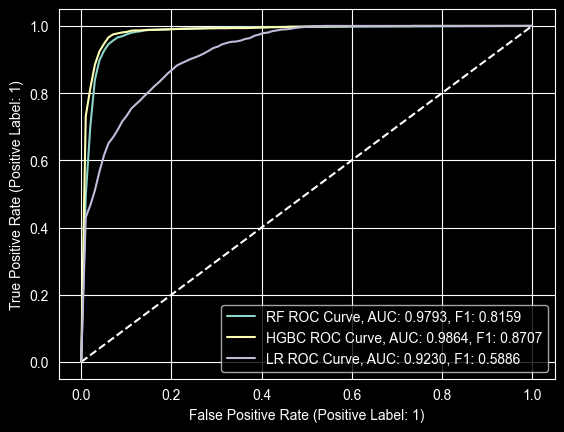

In [109]:
scaling_step = ColumnTransformer(transformers=[('scale', MinMaxScaler(), predictor_keys)])

model_pipelines = {
    'RF' : make_pipeline(scaling_step, RandomForestClassifier(class_weight = 'balanced_subsample')), #balanced class weight to compensate for unbalanced class label freq
    'HGBC' : make_pipeline(scaling_step, HistGradientBoostingClassifier(class_weight = 'balanced')),
    'LR' : make_pipeline(scaling_step, LogisticRegression(class_weight = 'balanced')) 
}

make_cv_roc(model_pipelines, df)

While logistic regression did fairly well, random forest and hgbc beat it out in both area under curve (AUC) and F1 score significantly without any tuning. Let's tune these two trees to see if we can differentiate better between them to make a final decision on which one we want to go with.

## Hyperparameter Searching <a class="anchor" name="4"></a>


For this project, we'll stay simple with grid searching. I'd like to discuss why I've chosen the values and parameters I have to search. 

The two objectives I have in mind are:
1. Tuning the model complexity, allowing the search to find that thin line between over and underfitting
2. Resource use, trying to reduce the end model's training and inference time. Also not letting the search itself get too big

By repeatadly doing smaller grid searches I can often find the right variables I need to do a bigger search and what range to do it over. This search is the big one that came out of that experimentation.

I do stratefied k fold validation for the grid search, the stratification helps to make sure we handle our uneven class labels properly. We don't want a training fold with little or no positive churn. We'll use 5 folds since that's typically a good amount with 3 repeats to make sure we're not just getting an odd run of luck.

In [96]:
RF_hp = {
    'randomforestclassifier__min_samples_leaf' : [1, 2, 3], #key naming convention from sklearn, double __ after classifier class followed by the param you wish to search
    'randomforestclassifier__n_estimators' : [250, 500, 750, 1000],
    'randomforestclassifier__max_depth' : [None, 20, 30],
}

HGBC_hp = {
    'histgradientboostingclassifier__min_samples_leaf' : [26, 31, 36, 41],
    'histgradientboostingclassifier__learning_rate' : [1e-2, 1e-1, 2.5e-1],
    'histgradientboostingclassifier__l2_regularization' : [0, 1e-2, 1e-1, 2.5e-1],
    'histgradientboostingclassifier__max_iter' : [50, 100, 150, 250]
}

hp_grid = {
    'RF' : RF_hp,
    'HGBC' : HGBC_hp
}

RF_HP_params = dict(
    min_samples_leaf = [1, 2, 3],
    n_estimators = [100, 250, 500, 1000],
    max_depth = [None, 10, 20, 30],
)

In [97]:
model_pipelines = {
    'RF' : make_pipeline(scaling_step, RandomForestClassifier(class_weight = 'balanced_subsample')), #balanced class weight to compensate for unbalanced class label freq
    'HGBC' : make_pipeline(scaling_step, HistGradientBoostingClassifier(class_weight = 'balanced'))
}

In [98]:
grid_search_models = {}
for model_name, model in model_pipelines.items():
    print(f'Starting fit on {model_name}')
    grid_search = GridSearchCV(estimator = model, 
                               param_grid= hp_grid[model_name], 
                               cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5), 
                               n_jobs =-1, 
                               scoring = 'f1', verbose = 10) #f1 scoring because it considers both true and false positives
    grid_search.fit(df[predictor_keys], df[label_key].values.ravel())
    grid_search_models[model_name] = grid_search


Starting fit on RF
Fitting 25 folds for each of 36 candidates, totalling 900 fits
Starting fit on HGBC
Fitting 25 folds for each of 192 candidates, totalling 4800 fits


## Choosing a model

Now that we have the results from our rid search let's plot the average f1 score with 1 standard deviation on either side to make sure we choose a model with all the information we just made with that repeated cross validation. I'll only plot the top five performers (highest performing at the top decrementing).


In [186]:
pretty_model_names = {
    'RF' : "Random Forest",
    'HGBC' : "Histogram Gradient Boosted Classifier"
}

def make_comparison_figs(grid_search_models, parameter_of_interest, xlabel):
    for model_name, model_search in grid_search_models.items():
        error_plotter = pd.DataFrame(model_search.cv_results_)
        if model_name == 'RF':
            error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['randomforestclassifier__min_samples_leaf']}, "
                                                                    f"N Est: {x['randomforestclassifier__n_estimators']}, "
                                                                    f"MD: {x['randomforestclassifier__max_depth']}")
        else:
            error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['histgradientboostingclassifier__min_samples_leaf']}, "
                                                                    f"LR: {x['histgradientboostingclassifier__learning_rate']}, "
                                                                    f"L2: {x['histgradientboostingclassifier__l2_regularization']}, "
                                                                    f"Max Iter: {x['histgradientboostingclassifier__max_iter']}")
            
        model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-5:]

        fig, ax = plt.subplots(figsize = (7,.5*len(model_perf_sort_inds)))
        plt.errorbar(error_plotter[f'mean_{parameter_of_interest}'].values[model_perf_sort_inds], 
                    range(len(model_perf_sort_inds)),
                    xerr = error_plotter[f'std_{parameter_of_interest}'].values[model_perf_sort_inds], fmt='o', color=my_blue,elinewidth= 2.5)
        ax.grid(False)
        plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
        plt.xlabel(xlabel)
        plt.title(f'{pretty_model_names[model_name]}, {xlabel}')
        plt.tight_layout()

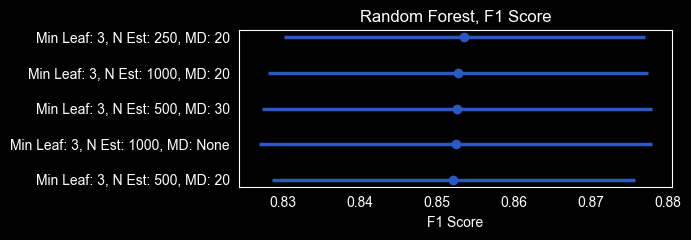

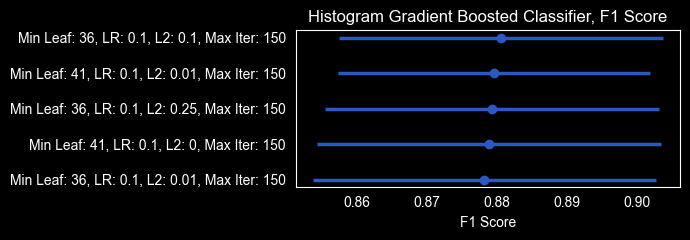

In [187]:
make_comparison_figs(grid_search_models, 'test_score', 'F1 Score')

Let's also check the inference and fit times for the top five performers (highest performing at the top decrementing).

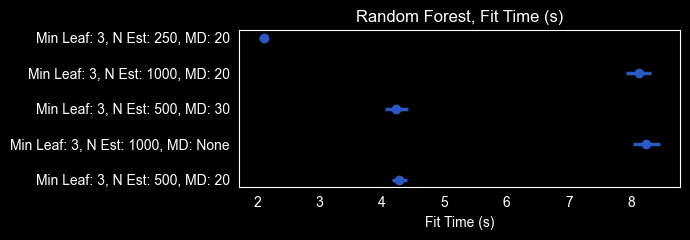

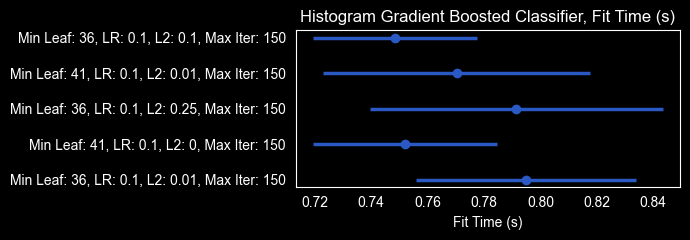

In [188]:
make_comparison_figs(grid_search_models, 'fit_time', 'Fit Time (s)')

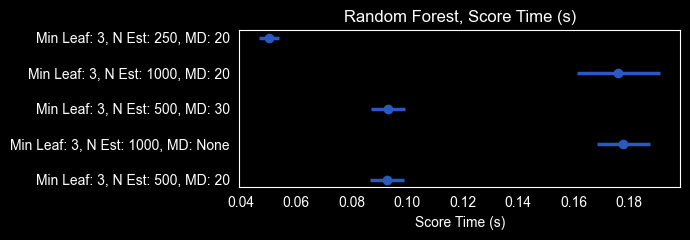

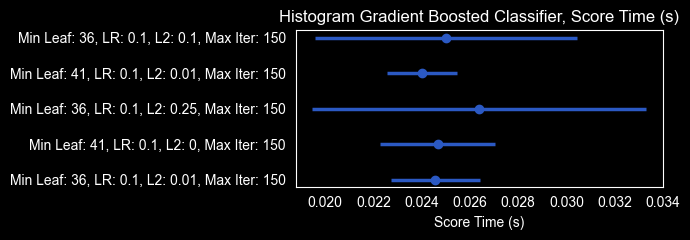

In [189]:
make_comparison_figs(grid_search_models, 'score_time', 'Score Time (s)')

Between the RF and HGBC models the HGBC win hands down. Not only do the HGBC models have higher average f1 score (~0.85 for the RF top performer vs ~0.88 for the HGBC) they also train and evaluate about 10x faster than random forest. Interestingly, the standard deviation in the f1 score peformance is about the same between the RF and HGBC models at around 2.5.

There aren't many stark differentiators between the top 5 HGBC candidates so we'll take the one with the highest average f1 score since the fit and score times are barely different for the top 5.

That means our best tuned model is sklearn's HistGradientBoostingClassifier with the follow kwargs
- class_weight = 'balanced'
- min_samples_leaf = 36
- learning_rate = 0.1
- l2_regularization = 0.1
- max_iter = 150

Now that we have our final model candidate, let's take a look at the roc curve to make sure our tuning efforts led to better performance. I'm cranking up the number of repeats we're doing here for the next section.

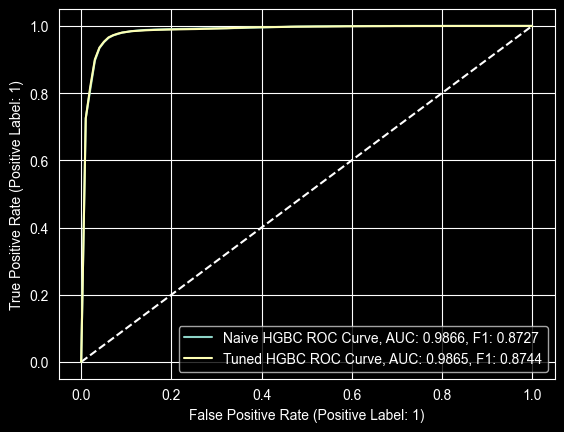

In [143]:
scaling_step = ColumnTransformer(transformers=[('scale', MinMaxScaler(), predictor_keys)])

testing_pipelines = {
    'Naive HGBC' : make_pipeline(scaling_step, HistGradientBoostingClassifier(class_weight = 'balanced')),
    'Tuned HGBC' : make_pipeline(scaling_step, HistGradientBoostingClassifier(class_weight = 'balanced', min_samples_leaf=36, learning_rate=0.1, l2_regularization=.1, max_iter=150))
}

f1_auc_info = make_cv_roc(testing_pipelines, df, return_f1_auc = True, n_repeat_cv = 50)

They appear to be the same, let's use all the information we have and plot the contrast distributions for F1 and AUC just to make sure.

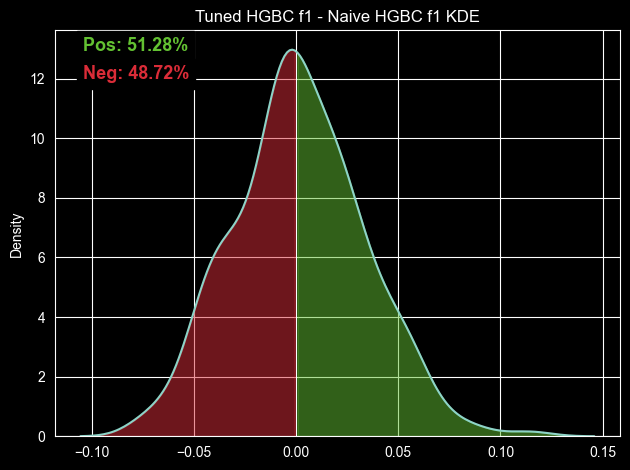

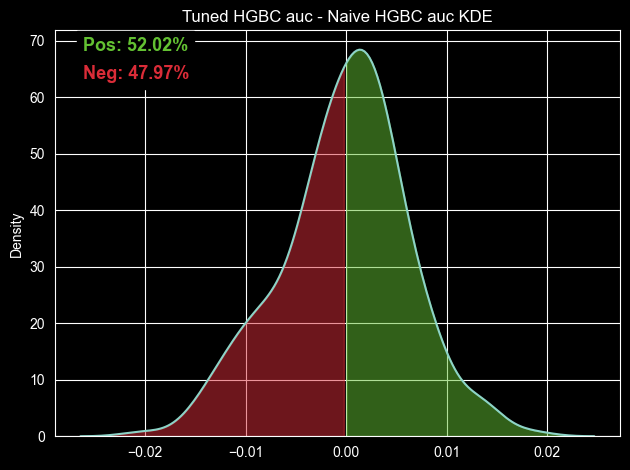

In [218]:
for var in ['f1', 'auc']:
    plt.figure()
    differences = f1_auc_info['Tuned HGBC'][var] - f1_auc_info['Naive HGBC'][var]
    
    kde_dat = sns.kdeplot(differences)
    kde_vals = kde_dat.get_lines()[0].get_data()[1]
    x_vals = kde_dat.get_lines()[0].get_data()[0]
    if I_like_dark_mode_plots:
        plt.fill_between(x_vals[x_vals > 0], kde_vals[x_vals > 0], color=my_green, alpha=0.5)
        plt.fill_between(x_vals[x_vals < 0], kde_vals[x_vals < 0], color=my_red, alpha=0.5)
    else:
        plt.fill_between(x_vals[x_vals > 0], kde_vals[x_vals > 0], color='g', alpha=0.5)
        plt.fill_between(x_vals[x_vals < 0], kde_vals[x_vals < 0], color='r', alpha=0.5)

    tot_density = np.trapz(x_vals, kde_vals)

    zero_ind = np.argmin(np.abs(x_vals))

    pos_density = np.trapz(x_vals[zero_ind:], kde_vals[zero_ind:]) / tot_density * 100
    neg_density = np.trapz(x_vals[:zero_ind], kde_vals[:zero_ind])/ tot_density * 100

    if I_like_dark_mode_plots:
        t = plt.text(0.05, 0.95, f'Pos: {pos_density:.2f}%', color=my_green,
                transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        t.set_bbox(dict(facecolor='black', edgecolor ='black'))
    else:
        t = plt.text(0.05, 0.95, f'Pos: {pos_density:.2f}%', color='k',
                transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        
        t.set_bbox(dict(facecolor='white', edgecolor ='white'))

    
    if I_like_dark_mode_plots:
        t = plt.text(0.05, 0.88, f'Neg: {neg_density:.2f}%', 
                     color=my_red, transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        t.set_bbox(dict(facecolor='black', edgecolor ='black'))
    else:
        t = plt.text(0.05, 0.88, f'Neg: {neg_density:.2f}%', 
                     color='k', transform=plt.gca().transAxes, fontsize = 13, fontweight = 'semibold')
        
        t.set_bbox(dict(facecolor='white', edgecolor ='white'))

    plt.title(f'Tuned HGBC {var} - Naive HGBC {var} KDE')
    plt.tight_layout()

So this tells us that *on average* we'll have a better f1 score and auc with our tuned model. It's very slight at only about a 1% edge on F1 and 2% edge on AUC but if we want to squeeze the best performance out of this model this tells us we are better off using our tuned version.

## Final model performance and feature importance 

It's been a journey, thanks for sticking with me (or skipping to the bottom with the ToC, you can stay too I suppose). Now that we have our final model, let's do another stratified k fold cross validation to generate a confusion matrix.

If you're just joining me here, our final model for the rest of this notebook will be sklearn's HistGradientBoostingClassifier with the follow kwargs
- class_weight = 'balanced'
- min_samples_leaf = 36
- learning_rate = 0.1
- l2_regularization = 0.1
- max_iter = 150

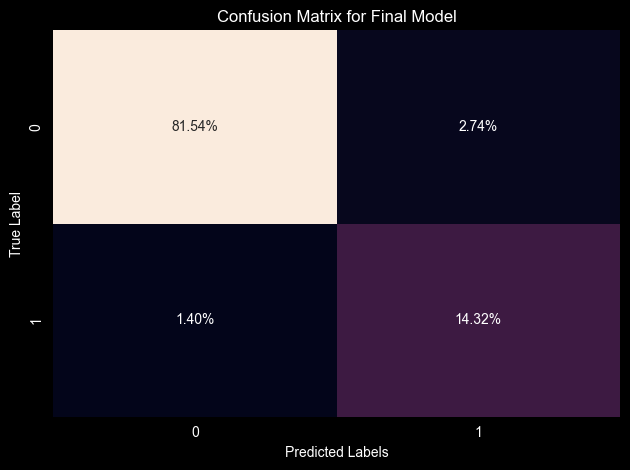

In [225]:
final_model = make_pipeline(scaling_step, HistGradientBoostingClassifier(class_weight = 'balanced', min_samples_leaf=36, learning_rate=0.1, l2_regularization=.1, max_iter=150))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
cm = np.zeros((2,2))

for train_inds, test_inds in cv.split(df[predictor_keys], df[label_key].values.ravel()):
    Xtrain = df[predictor_keys].iloc[train_inds]
    Xtest = df[predictor_keys].iloc[test_inds]
    Ytrain = df[label_key].values.ravel()[train_inds]
    Ytest = df[label_key].values.ravel()[test_inds]

    fit_model = final_model.fit(Xtrain, Ytrain)
    y_pred = fit_model.predict(Xtest)
    cm += metrics.confusion_matrix(Ytest, y_pred)

cm = cm / np.sum(cm) * 100

# def fmt(x):
#     return f'{x:.2f}%'

ax = sns.heatmap(cm, annot=True, fmt='.2f', cbar=False)
for text in ax.texts:
    text.set_text(text.get_text() + '%')
plt.title('Confusion Matrix for Final Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Label')
plt.tight_layout()

In [ ]:
RF_HP_params = dict(
    min_samples_leaf = [1, 2, 3],
    n_estimators = [100, 250, 500, 1000],
    max_depth = [None, 10, 20, 30],
)

HGBC_HP_params = dict(
    min_samples_leaf = [10, 20, 30, 40],
    learning_rate = [1e-2, 1e-1, 2.5e-1],
    l2_regularization = [0, 1e-2, 1e-1, 2.5e-1],
    max_iter = [50, 100, 150, 250]
)

RF_model = RandomForestClassifier(class_weight = 'balanced_subsample')
HGBC_model = HistGradientBoostingClassifier(class_weight = 'balanced')

RF_grid_search = GridSearchCV(estimator = RF_model, param_grid= RF_HP_params, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1), n_jobs =-1, scoring = 'f1', verbose = 10)
HGBC_grid_search = GridSearchCV(estimator = HGBC_model, param_grid= HGBC_HP_params, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1), n_jobs=-1, scoring = 'f1', verbose =10)


In [ ]:
RF_grid_search.fit(df[predictor_keys], df[label_key].values.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(class_weight='balanced_subsample'),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 250, 500, 1000]},
             scoring='f1', verbose=10)

In [ ]:
doge = RF_grid_search.cv_results_

In [ ]:
RF_grid_search.cv_results_

{'mean_fit_time': array([0.73047915, 1.67649183, 3.37811499, 6.90751338, 0.65379353,
        1.50093498, 3.16783838, 6.31393952, 0.62924514, 1.52688012,
        2.9983098 , 7.19675503, 0.57310715, 1.69177365, 3.68577399,
        6.94893479, 0.74793248, 2.0794558 , 4.24255571, 7.03613257,
        0.73569388, 1.86620045, 3.55529752, 7.89657917, 0.82046208,
        2.26513519, 4.34528055, 9.87696066, 0.84658747, 2.24820752,
        4.61980009, 9.24703469, 1.06875658, 2.20264158, 4.16267767,
        8.44230042, 0.86164093, 2.18147306, 4.52694378, 9.17673011,
        0.83512092, 2.19252715, 4.47863574, 8.59449401, 0.78773232,
        2.0541121 , 4.2061069 , 6.00132403]),
 'std_fit_time': array([0.07887325, 0.10838066, 0.31805067, 0.61431647, 0.04082574,
        0.07048051, 0.19770134, 0.28636406, 0.01072177, 0.10347636,
        0.13150899, 0.55774573, 0.05842851, 0.31007623, 0.55354422,
        0.46998228, 0.12933394, 0.41682373, 0.40995562, 0.63820786,
        0.11658234, 0.22985424, 0.093

In [ ]:
error_plotter = pd.DataFrame(RF_grid_search.cv_results_)
error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, N Est: {x['n_estimators']} MD: {x['max_depth']}")
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)

plt.subplots(figsize = (7,10))
plt.errorbar(error_plotter['mean_test_score'].values[model_perf_sort_inds], 
             range(len(error_plotter['params'])),
             xerr = error_plotter['std_test_score'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(error_plotter['params'])), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()


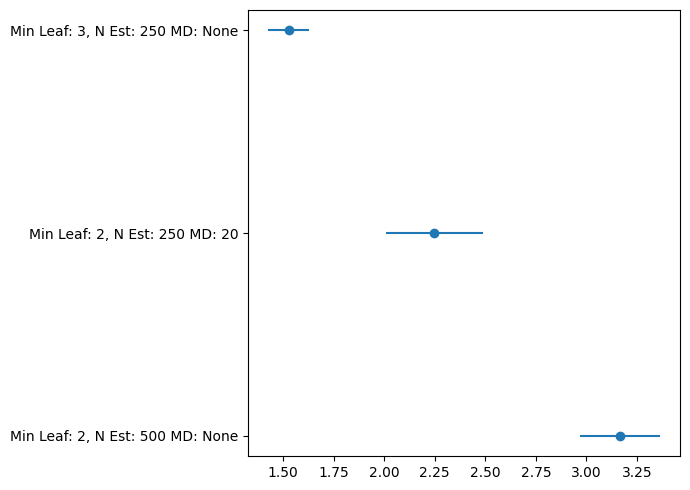

In [ ]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_fit_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_fit_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

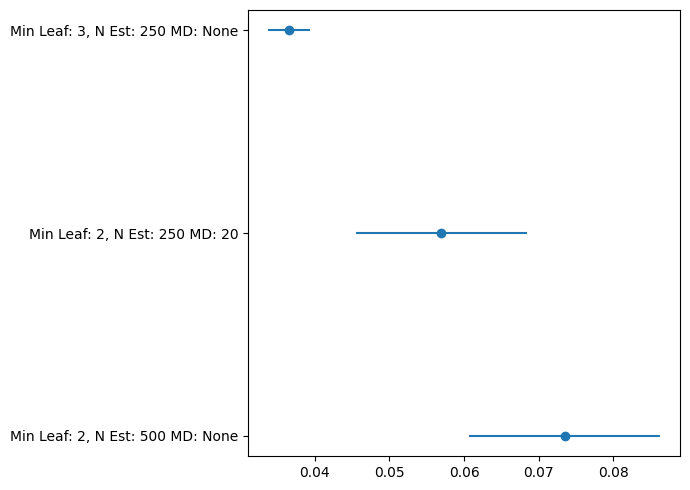

In [ ]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_score_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_score_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

In [ ]:
HGBC_grid_search.fit(df[predictor_keys], df[label_key].values.ravel())

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=None),
             estimator=HistGradientBoostingClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.01, 0.1, 0.25],
                         'learning_rate': [0.01, 0.1, 0.25],
                         'max_iter': [50, 100, 150, 250],
                         'min_samples_leaf': [10, 20, 30, 40]},
             scoring='f1', verbose=10)

In [ ]:
error_plotter = pd.DataFrame(HGBC_grid_search.cv_results_)
error_plotter['params'] = error_plotter['params'].apply(lambda x: f"Min Leaf: {x['min_samples_leaf']}, LR: {x['learning_rate']}, L2: {x['l2_regularization']}, Max Iter: {x['max_iter']}")

model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)

plt.subplots(figsize = (7,25))
plt.errorbar(error_plotter['mean_test_score'].values[model_perf_sort_inds], 
             range(len(error_plotter['params'])),
             xerr = error_plotter['std_test_score'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(error_plotter['params'])), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

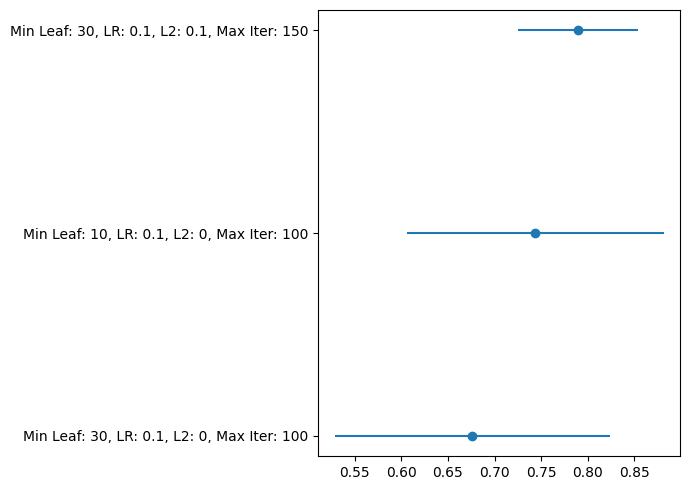

In [ ]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_fit_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_fit_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

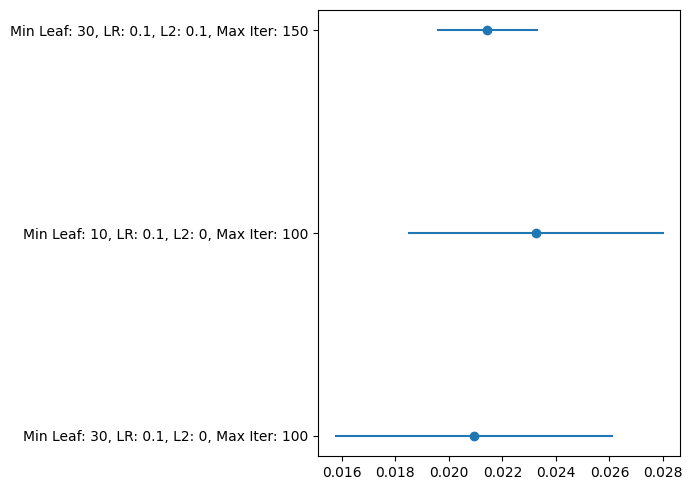

In [ ]:
model_perf_sort_inds = np.argsort(error_plotter['mean_test_score'].values)[-3:]

plt.subplots(figsize = (7,5))
plt.errorbar(error_plotter['mean_score_time'].values[model_perf_sort_inds], 
             range(len(model_perf_sort_inds)),
             xerr = error_plotter['std_score_time'].values[model_perf_sort_inds], fmt='o')

plt.yticks(range(len(model_perf_sort_inds)), error_plotter['params'].values[model_perf_sort_inds]);
plt.tight_layout()

In [ ]:
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

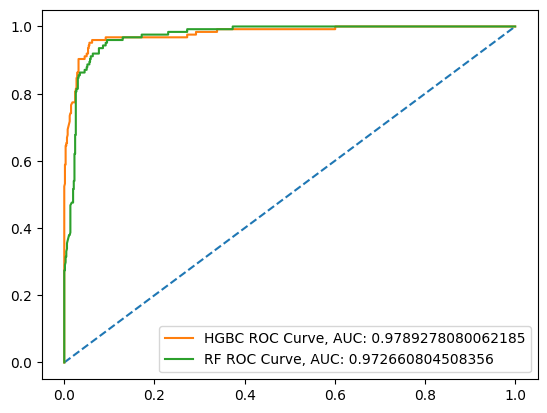

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), stratify=df[label_key].values.ravel())
best_RF_model = RF_grid_search.best_estimator_.fit(Xtrain, Ytrain)
best_HGBC_model = HGBC_grid_search.best_estimator_.fit(Xtrain, Ytrain)

plt.figure()
plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle = 'dashed')
for model, name in zip([best_HGBC_model, best_RF_model],['HGBC', 'RF']):
    fpr, tpr, thresholds = roc_curve(Ytest, model.predict_proba(Xtest)[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'{name} ROC Curve, AUC: {auc}')

plt.legend()
plt.show()

In [ ]:
#let's move forward with the HGBC, first to make sure we get a nice stable threshold
ideal_thres_stack = []
for i in range(50):
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
    best_HGBC_model.fit(Xtrain, Ytrain)
    fpr, tpr, thresholds = roc_curve(Ytest, best_HGBC_model.predict_proba(Xtest)[:,1])

    gmeans = np.sqrt(tpr*(1-fpr))
    ideal_thres_stack.append(np.argmax(gmeans))
ideal_thres = np.round(np.mean(ideal_thres_stack))

In [ ]:
ideal_thres = np.round(np.mean(ideal_thres_stack))

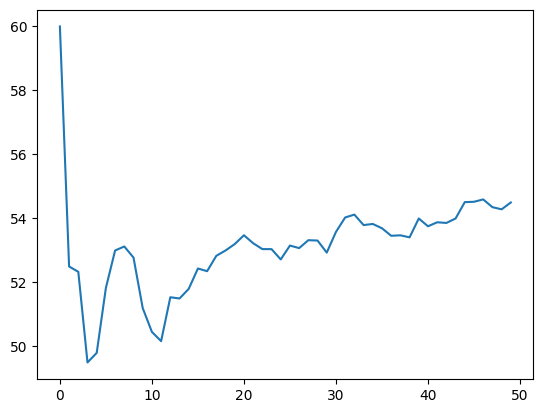

In [ ]:
plt.plot(np.cumsum(ideal_thres_stack)/(np.arange(len(ideal_thres_stack))+1))

In [ ]:
class reThresh_HGBC:
    def __init__(self, model, thresh = 0.5) -> None:
        self.model = model
        self.thresh = thresh
    def predict(self, X) -> int:
        return (self.model.predict_proba(X)[:,1]*100>=self.thresh).astype(int)
    def fit(self, X, Y) -> None:
        self.model = self.model.fit(X, Y)
    def predict_proba(self, X):
        return self.model.predict_proba(X)

In [ ]:
final_model = reThresh_HGBC(best_HGBC_model, ideal_thres)
perform = {'Tuned HGBC': [], 'Untuned HGBC':[]}
for model, model_name in zip([final_model, best_HGBC_model], ['Tuned HGBC', 'Untuned HGBC']):
    for i in range(50):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
        model.fit(Xtrain, Ytrain)
        perform[model_name].append(metrics.f1_score(Ytest, model.predict(Xtest)))


<Axes: >

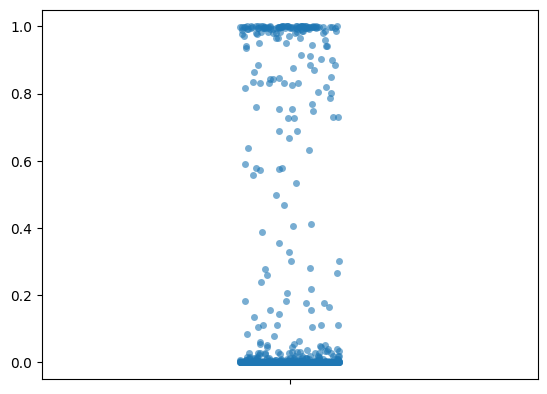

In [ ]:
best_HGBC_model.fit(Xtrain, Ytrain)
proba = best_HGBC_model.predict_proba(Xtest)[:,1]
sns.stripplot(y=proba, alpha=0.6)

In [ ]:
for model_name, f1s in perform.items():
    print(f'{model_name} has a mean f1 of {np.mean(f1s)} with a std of {np.std(f1s)}')

Tuned HGBC has a mean f1 of 0.8651024849560334 with a std of 0.017264108600066858
Untuned HGBC has a mean f1 of 0.871039396288133 with a std of 0.02021913474561472


In [ ]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
best_HGBC_model.fit(Xtrain, Ytrain)
final_model.fit(Xtrain, Ytrain)



In [ ]:
y_prob = best_HGBC_model.predict_proba(Xtest)[:, 1]
prob_true, prob_pred = calibration_curve(Ytest, y_prob, n_bins=20)
calD = CalibrationDisplay(prob_true, prob_pred, y_prob)
calD.plot()

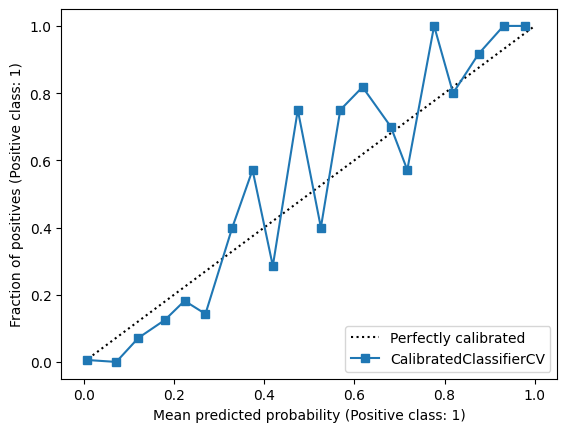

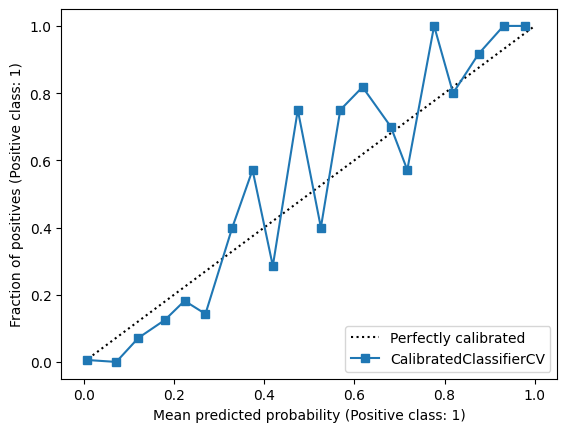

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_HGBC = CalibratedClassifierCV(best_HGBC_model)
calibrated_HGBC.fit(Xtrain, Ytrain)
calD = CalibrationDisplay.from_estimator(calibrated_HGBC, Xtest, Ytest, n_bins=20)
calD.plot()

In [ ]:

perform = {'Calibrated HGBC': [], 'HGBC':[]}
for model, model_name in zip([calibrated_HGBC, best_HGBC_model], ['Calibrated HGBC', 'HGBC']):
    for i in range(50):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[predictor_keys], df[label_key].values.ravel(), test_size=0.3, stratify=df[label_key].values.ravel())
        model.fit(Xtrain, Ytrain)
        perform[model_name].append(metrics.f1_score(Ytest, model.predict(Xtest)))


In [ ]:
for model_name, f1s in perform.items():
    print(f'{model_name} has a mean f1 of {np.mean(f1s)} with a std of {np.std(f1s)}')

Calibrated HGBC has a mean f1 of 0.8562125840460473 with a std of 0.017878984997965957
HGBC has a mean f1 of 0.8641713930339351 with a std of 0.02117152560968184


<Axes: >

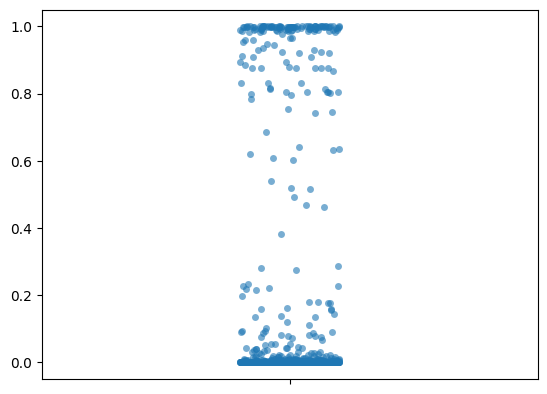

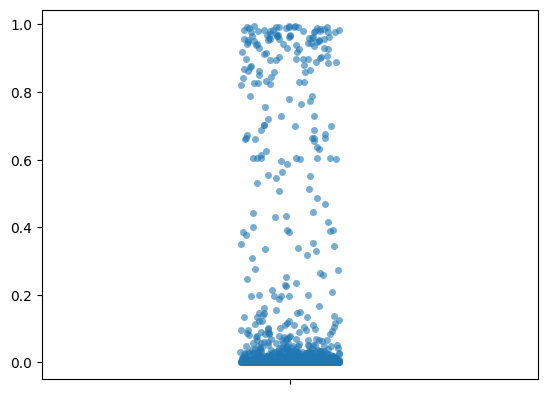

In [ ]:
best_HGBC_model.fit(Xtrain, Ytrain)
proba = best_HGBC_model.predict_proba(Xtest)[:,1]
sns.stripplot(y=proba, alpha=0.6)
plt.figure()
calibrated_HGBC.fit(Xtrain, Ytrain)
proba = calibrated_HGBC.predict_proba(Xtest)[:,1]
sns.stripplot(y=proba, alpha=0.6)

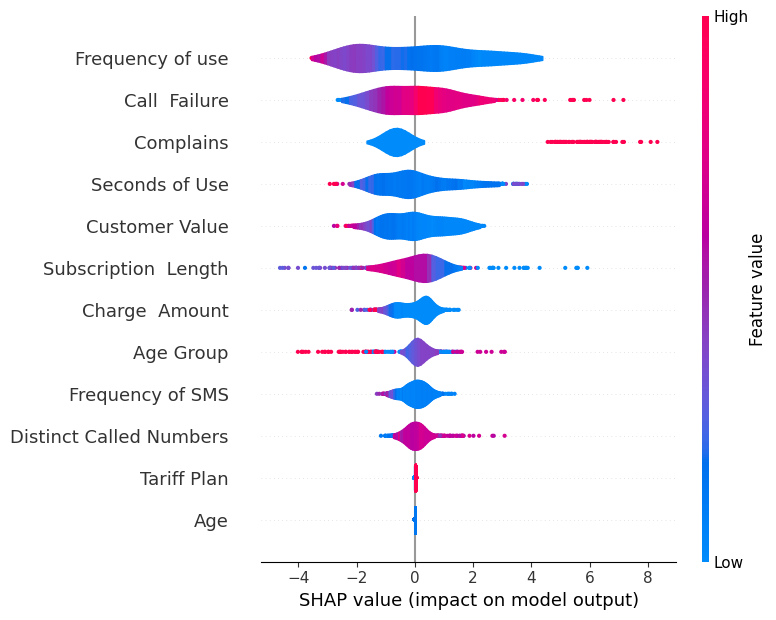

In [ ]:
explainer = shap.TreeExplainer(best_HGBC_model)
shap_values = explainer.shap_values(Xtest)
shap.summary_plot(shap_values, Xtest, plot_type="violin")

In [ ]:
mean_shap = np.mean(shap_values, axis =0)